In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%matplotlib inline

In [26]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from itertools import groupby
from scipy.stats import norm
from arch.unitroot import VarianceRatio
from sgmresearchbase.coint.common import hurst_naive

from sgmbasketball.models.factor_model.play_by_play_data import PlayByPlayCleanData
from stratagemdataprocessing.data_api import get_basketball_event_action_data, find_basketball_events

from sgmresearchbase.coint.space import normalise
from sgmresearchbase.coint.services import CointegrationService
from sgmresearchbase.coint.johansen import Johansen, JohansenError
from sgmresearchbase.coint.projection import interpolate

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)

In [33]:
START_DT = datetime.datetime(2016, 10, 1)
END_DT = datetime.datetime(2017, 6, 1)

ALL_EVENTS = find_basketball_events(START_DT, END_DT, True)
NBA_EVENTS = filter(lambda e: e['stage_name'] == 'NBA', ALL_EVENTS)

PBP = PlayByPlayCleanData(str(START_DT)[0:10], str(END_DT)[0:10], 'NBA', 'pbp',
                          fixture_filter=None, use_cache=False).get_data_ready()

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): data-api.stratagem.co
INFO:sgmresearchbase.models.factor_model.raw_data:Data ready, parsing events
/home/tspooner/stratagem-basketball/sgmbasketball/models/transition_sim/data.py:238: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  d_out = d_out.sort(['fixture_id', 'period', 'clock', 'tmp_id', 'is_inb'],ascending=[True,True,False,True,True]).drop(['is_inb'], axis=1)
/home/tspooner/stratagem-basketball/sgmbasketball/models/transition_sim/data.py:126: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  ascending=[True, True, False, True, True])
/home/tspooner/stratagem-basketball/sgmbasketball/models/transition_sim/data.py:276: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  ascending=[True, True, False, True, False]).drop(['is_ftx'], axis=1)
INFO:sgmresearchbase.models.factor_model.raw_data:Events to transitions
INFO:sgmresear

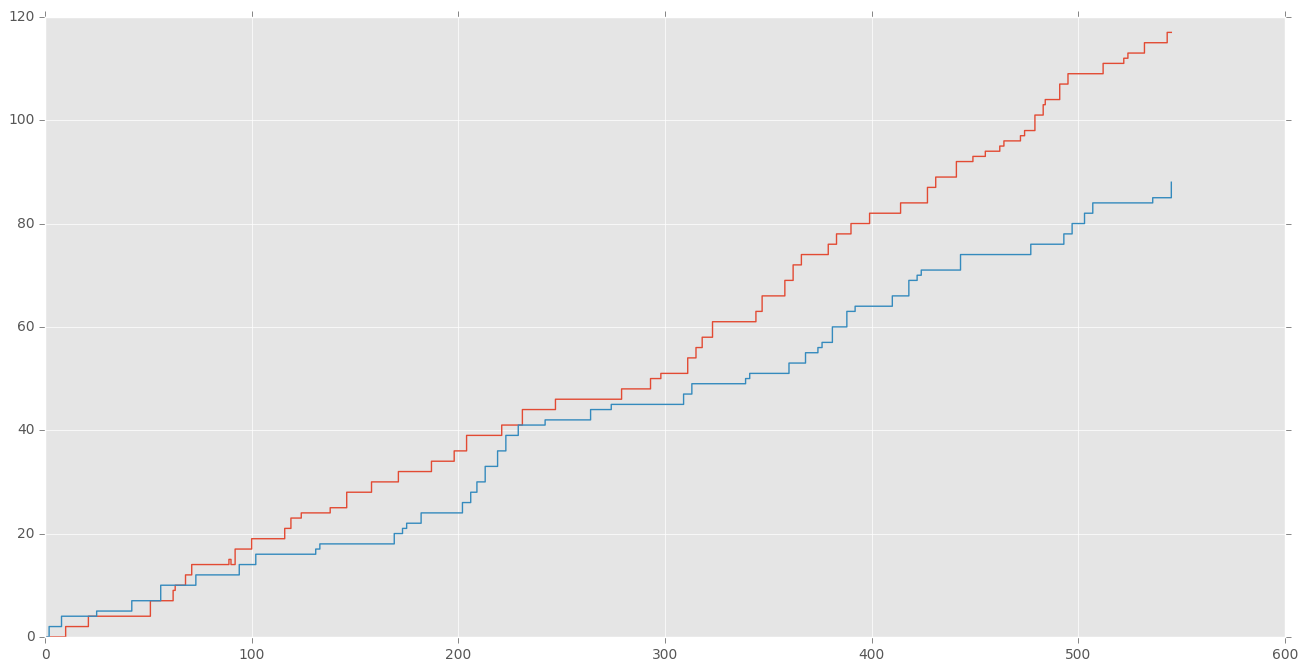

In [48]:
plt.plot(PBP.loc[2352830, 'points_h'].values, drawstyle='steps-post')
plt.plot(PBP.loc[2352830, 'points_a'].values, drawstyle='steps-post')

In [7]:
def get_action_data(eid):
    act_dat = get_basketball_event_action_data(eid)
    act_df = format_action_dat(act_dat)

    act_df['team1_score'] = act_df['team1_score'].astype(int)
    act_df['team2_score'] = act_df['team2_score'].astype(int)

    act_df['timestamp'] = pd.to_datetime(act_df['real_time'])
    del act_df['real_time']

    act_df['elapsed'] = act_df['timestamp'].apply(lambda v: (v - act_df['timestamp'].iloc[0]).total_seconds())

    act_df['tp'] = act_df.team1_score + act_df.team2_score
    act_df['ps'] = act_df.team1_score - act_df.team2_score

    return act_df.set_index('elapsed')

In [8]:
def do_coint_work(X, model=0, sl=1):
    j = Johansen(X, model, k=2, significance_level=sl)

    try:
        eigenvectors, eigenvalues = j.mle()

        if eigenvectors.shape[1] == 2:
            bases = normalise(eigenvectors)
            if bases[0, 0] < 0:
                bases[:, 0] = -bases[:, 0]

            if bases[0, 1] < 0:
                bases[:, 1] = -bases[:, 1]

            return bases, eigenvalues

        else:
            return None

    except JohansenError:
        return None

In [9]:
def _zs(vals):
    return (vals - np.mean(vals, axis=0)) / np.std(vals, axis=0)

In [18]:
df = get_action_data(NBA_EVENTS[132]['event_id'])

X = np.array([
    interpolate(df.index.values, df.team1_score.values, order=0),
    interpolate(df.index.values, df.team2_score.values, order=0)
]).T

spd = _zs(np.dot(X, do_coint_work(X, model=1)[0][:, 0]))

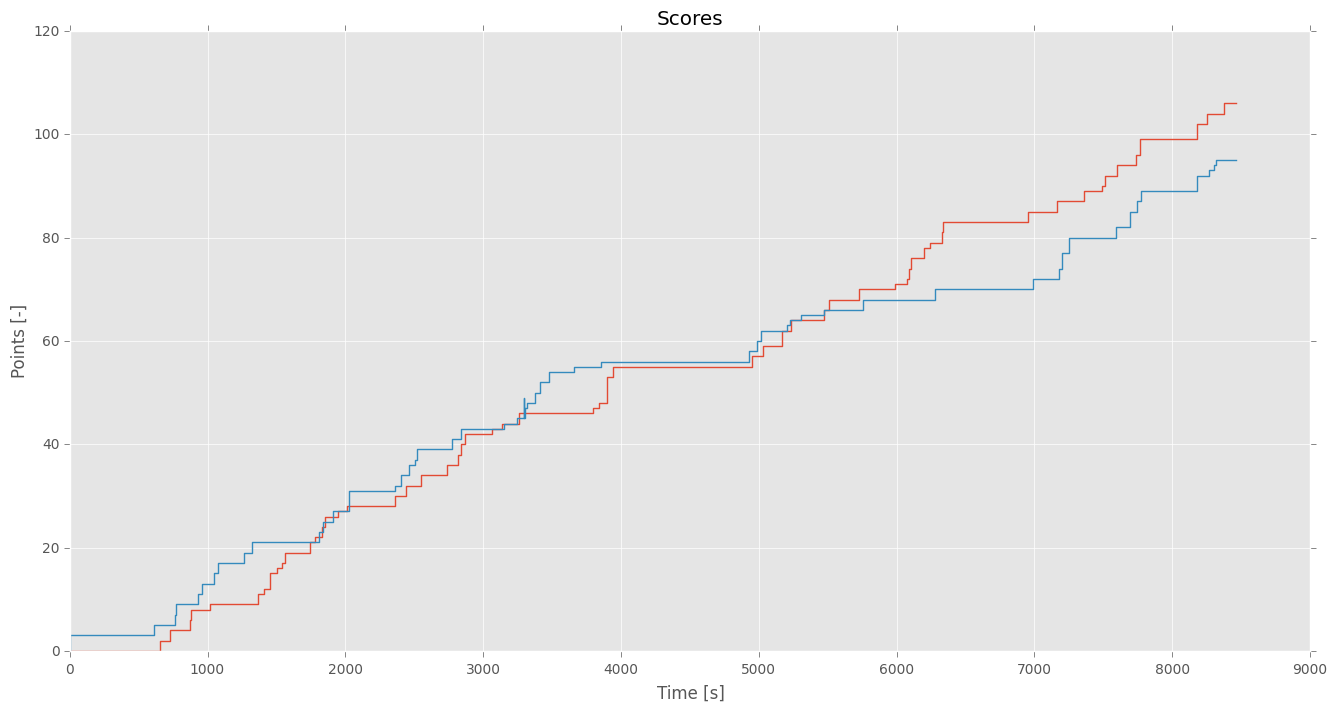

In [23]:
plt.step(df.index, df.team1_score)
plt.step(df.index, df.team2_score)

plt.title('Scores')
plt.xlabel('Time [s]')
plt.ylabel('Points [-]')

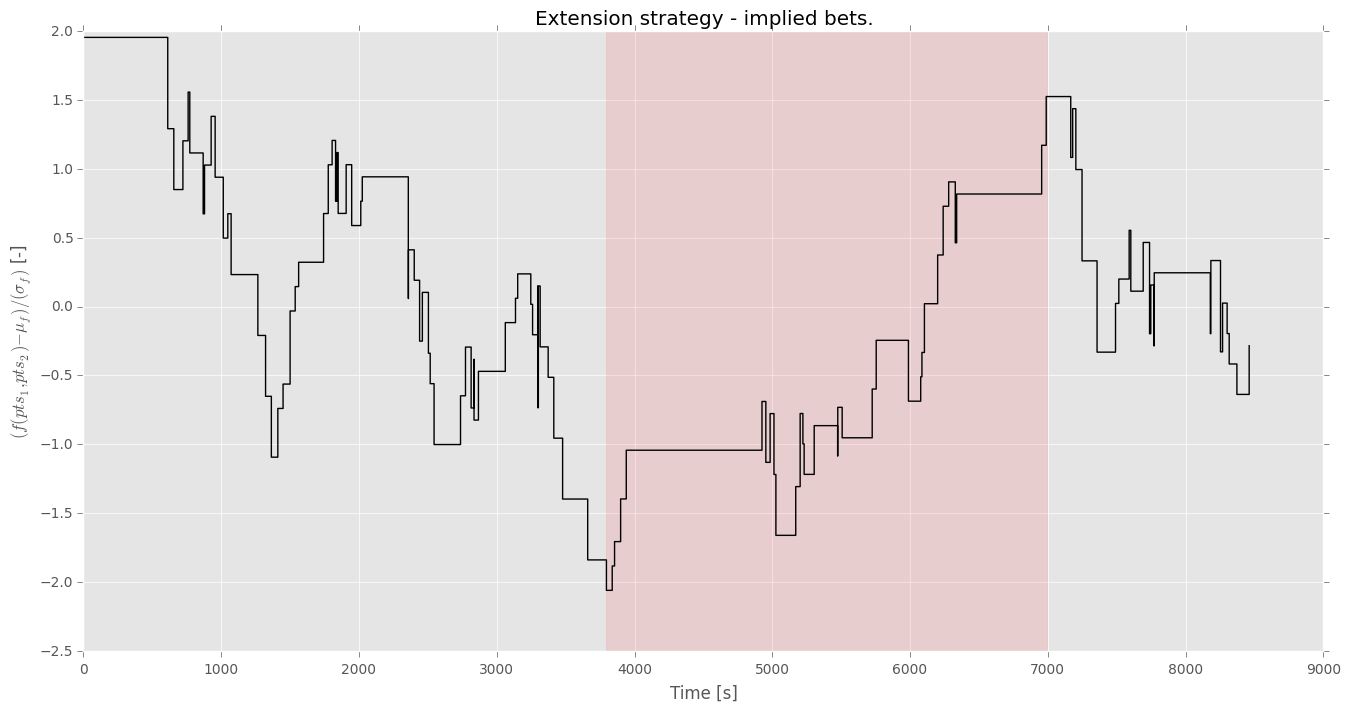

In [20]:
spd_normed = _zs(spd)

plt.figure()
plt.plot(spd_normed, drawstyle='steps-post', label='Spread', color='k')
plt.title('Extension strategy - implied bets.')
plt.xlabel('Time [s]')
plt.ylabel('$(f(pts_1, pts_2) - \\mu_f)/(\\sigma_f)$ [-]')

groups = zero_runs(spd_normed > -2)
if len(groups) > 0:
    for tr in groups:
        close_index = np.argmax(spd_normed[tr[0]:] > 1)
        next_index = tr[1]+close_index if close_index > 0 else spd_normed.shape[0]

        plt.axvspan(tr[0], next_index, color='red', alpha=0.1)

groups = zero_runs(spd_normed < 2)
if len(groups) > 0:
    for tr in groups:
        close_index = np.argmax(spd_normed[tr[0]:] < -1)
        next_index = tr[1]+close_index if close_index > 0 else spd_normed.shape[0]

        plt.axvspan(tr[0], next_index, color='blue', alpha=0.1)